## **Perkenalan**

Nama  : Dendy Dwinanda

---

## **Objektive**

Menganalisis data penjualan perusahaan pada tahun 2010 dan menjelaskan performa penjualan pada setiap target pasar.

---

## ***Import Libraries***

---

In [ ]:
!pip install bokeh

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random
import requests

from collections import Counter
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.io import push_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.transform import factor_cmap, cumsum
from math import pi

import warnings
warnings.filterwarnings("ignore")

## ***Data Loading***

---

In [ ]:
# google drive file id file
file_id = '1oPMKiGyxjGjP1qNT7odcC8okusj3g7Xf'
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# download data dari drive
response = requests.get(download_url)
response.raise_for_status()

# Menyimpan konten ke temporary file CSV
csv_file_path = '/content/dataRetailOnline.csv'
with open(csv_file_path, 'wb') as file:
    file.write(response.content)

df = pd.read_csv(csv_file_path, encoding='latin1')

In [ ]:
# menampilkan 5 data teratas
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


## ***Data Cleaning***

---

In [ ]:
# menampilkan informasi keseluruhan data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


*Insight* :

Adapun keterangan untuk masing masing kolom yakni:

Kolom | Keterangan
--- | ---
`InvoiceNo` | Kode invoice pembelian barang
`StockCode` | Kode barang gudang
`Description` | Nama barang
`Quantity` | Jumlah pembelian barang
`InvoiceDate` | Tanggal pembelian barang
`UnitPrice` | Harga satuan barang
`CustomerID` | Kode ID customers
`Country` | Country

- Terdapat beberapa data yang mengandung null value sehingga akan dilakukan cleanning data.
- Kolom InvoiceDate masih bertype data object
- Tidak terdapat kolom jumlah total harga barang pada setiap item pembelian


In [ ]:
# menghapus data yang terdapat null value
df_cleaning = df.copy()

In [ ]:
# menampilkan jumlah data duplicate pada setiap kolom
df_cleaning.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
# menghapus data yang terdapat null value
df_cleaning = df_cleaning.dropna()

In [ ]:
# Mengubah nama kolom menjadi Items
df_cleaning = df_cleaning.rename(columns={'Description': 'Items'})

In [ ]:
# Convert ke dalam lowercase
df_cleaning['Items'] = df_cleaning['Items'].str.lower()

In [ ]:
# merubah type data pada kolom InvoiceDate menjadi datetime
df_cleaning['InvoiceDate'] = pd.to_datetime(df_cleaning['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [ ]:
# membuat tabel baru berdasarkan bulan dan tahun transaksi
df_cleaning['Year_Month'] = df_cleaning['InvoiceDate'].dt.to_period('M').astype(str)

In [ ]:
# menambahkan kolom total harga pada setiap pembelian
df_cleaning['TotalSell'] = df_cleaning['Quantity'] * df_cleaning['UnitPrice']

In [ ]:
# mengecek duplicated data
df_cleaning.duplicated().sum()

5225

In [ ]:
# menghapus duplicate
df_clean = df_cleaning.drop_duplicates()

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Items        401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      401604 non-null  object        
 8   Year_Month   401604 non-null  object        
 9   TotalSell    401604 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 33.7+ MB


*Insight* :

Pada dataframe `dataRetailOnline.csv` dapat ditemukan:
- Terdapat 1454 null value pada kolom dan 135080 null value pada kolom customer ID
- Data InvoiceDate sudah menjadi datetime64[ns]
- Terdapat 5225 data duplicated sehingga dihapus data duplicatenya.

---

## ***Exploratory Data Analysis***

In [ ]:
# Fungsi EDA untuk menampilkan 10 data teratas dengan Bar Plot
def plot_top_10(df, x_column, title=''):
    # Menghitung frekuensi setiap nilai dalam kolom dan mengambil 10 teratas
    top_10_values = df[x_column].value_counts().nlargest(10)

    # Membuat sumber data
    source = ColumnDataSource(data=dict(x=top_10_values.index.tolist(), y=top_10_values.values.tolist()))

    # Generate random colors
    random.seed(42)  # Memberikan seed agar warna acak konsisten
    colors = ["#%06x" % random.randint(0, 0xFFFFFF) for i in range(len(top_10_values))]

    # Membuat plot
    p = figure(x_range=top_10_values.index.tolist(), height=400, width=700, title=title,
               toolbar_location="below", tools="pan,box_zoom,wheel_zoom,reset,save")

    # Menambahkan bar plot dengan warna yang dihasilkan secara acak
    p.vbar(x='x', top='y', width=0.9, source=source,
           line_color='white', fill_color=factor_cmap('x', palette=colors, factors=top_10_values.index.tolist()),
           legend_field="x")

    # Menambahkan hover tool
    hover = HoverTool()
    hover.tooltips = [("Kategori", "@x"), ("Jumlah", "@y{0,0}")]
    p.add_tools(hover)

    p.xaxis.axis_label = title
    p.yaxis.axis_label = 'Count'
    p.xaxis.major_label_orientation = 1

    # Mengatur tulisan axis-x dan axis-y menjadi tebal (bold)
    p.xaxis.axis_label_text_font_style = "bold"
    p.yaxis.axis_label_text_font_style = "bold"

    # Mengatur ketebalan garis axis
    p.xaxis.axis_line_width = 1.1
    p.yaxis.axis_line_width = 1.1

    # Mengatur label axis menjadi tebal
    p.xaxis.major_label_text_font_style = "bold"
    p.yaxis.major_label_text_font_style = "bold"

    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    p.y_range.end = max(top_10_values.values) + 0.2 * max(top_10_values.values)

    # Mengatur judul plot
    p.title.text_font_size = '16pt'  # Ubah ukuran font judul
    p.title.text_font_style = 'bold'  # Ubah gaya font judul menjadi tebal
    p.title.align = "center"

    # Mengatur posisi legenda di luar plot
    p.legend.orientation = "vertical"
    p.legend.location = "top_right"
    p.legend.spacing = 10  # Menambahkan ruang antara legenda dan plot

    show(p)

In [ ]:
# Fungsi EDA Untuk Piechart
def pie_chart(data, title=''):
    categories = data.index
    values = data.values

    # Membuat data frame dari data yang diberikan
    df = pd.DataFrame({'category': categories, 'value': values})

    # Menghitung persentase untuk setiap kategori
    df['percentage'] = (df['value'] / df['value'].sum()) * 100

    # Menghitung sudut untuk setiap kategori
    df['angle'] = df['value'] / df['value'].sum() * 2 * pi

    # Membuat warna secara acak untuk setiap kategori
    colors = [f"#{random.randint(0, 0xFFFFFF):06x}" for _ in range(len(df))]
    df['color'] = colors

    # Buat figure untuk diagram pie
    p = figure(width=800, height=500, title=title, toolbar_location=None,
               tools="hover", tooltips="@category: @percentage{0.0}%, @value", x_range=(-0.5, 1.0))

    # Tambahkan wedge (irisan) ke figure
    p.wedge(x=0, y=1, radius=0.4,
            start_angle=cumsum('angle', include_zero=True),
            end_angle=cumsum('angle'),
            line_color="white", fill_color='color', legend_field='category', source=df)

    # Tambahkan HoverTool untuk menampilkan informasi tambahan
    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [("Category", "@category"), ("Percentage", "@percentage{0.0}%"), ("Value", "@value")]

    # Gaya dan pengaturan figure
    p.axis.axis_label = None
    p.axis.visible = False
    p.grid.grid_line_color = None
    p.title.align = 'center'
    p.title.text_font_size = '15pt'
    p.legend.title = 'Legend'
    p.legend.label_text_font_size = '10pt'

    # Tampilkan plot
    show(p)
    output_notebook()

In [ ]:
# Menampilkan 10 negara teratas
plot_top_10(df_clean, x_column="Country", title="Top 10 Countries")

In [ ]:
# Menghitung 10 negara teratas
top_sold_items = df_clean['Items'].value_counts().head(10)
pie_chart(top_sold_items, title="Top 10 Sold Items")

Insight:
- Pengamatan diatas menunjukan bahwa customers yang berdomisili di UK mendominasi jumlah item transaksi pada setiap hari selama 2010 dengan 356.728 item transaksi disusul oleh customer yang berdomisili di germany dengan 9.480 dan france dengan 8.475 item transaksi.
- Item yang sering dicari customers berupa White Hanging Heart T-Light Holder dengan value 2.058 disusul dengan Regency Cakestand 3 Tier sebanyak 1.894 dan Jumbo Bag Red Retrispot dengan 1.659

## ***Descriptive Analysis***

In [ ]:
# mengecek destritive statistic untuk data berbentuk angka
df_clean.describe(exclude = ['object', 'datetime64']).transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,401604.0,12.183273,250.283037,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,401604.0,3.474064,69.764035,0.0,1.25,1.95,3.75,38970.0
CustomerID,401604.0,15281.160818,1714.006089,12346.0,13939.00,15145.00,16784.00,18287.0
TotalSell,401604.0,20.613638,430.352218,-168469.6,4.25,11.70,19.80,168469.6


In [ ]:
# Menampilkan Central Tendency dari Total Price

avg_TotalSell = df_clean['TotalSell'].mean().round(3)
median_TotalSell = df_clean['TotalSell'].median()
std_TotalSell = df_clean['TotalSell'].std().round(3)
skew_TotalSell = df_clean['TotalSell'].skew().round(3)
kurtosis_TotalSell = df_clean['TotalSell'].kurtosis().round(3)

print("Average Total Sell: ", avg_TotalSell)
print("Median Total Sell: ", median_TotalSell)
print("Standar deviation Total Sell: ", std_TotalSell)
print("Skewness Total Sell:", skew_TotalSell)
print("Kurtosis Total Sell:", kurtosis_TotalSell)

Average Total Sell:  20.614
Median Total Sell:  11.7
Standar deviation Total Sell:  430.352
Skewness Total Sell: -0.058
Kurtosis Total Sell: 122445.266


Insigt:
- Dari Hasil Sentral Tendensi didapat nilai rata-rata penjualan pada setiap item pada suatu transaksi ada pada nilai 20,614 dengan nilai tengah data 11,7. Standar Deviasi menunjukan nilai 430,352 yang menunjukan nilai kolom Total Sell memiliki variansi data yang menyebar dari rata rata harga. Skewness Menunjukan kemiringan kurva data yang normal distribusi, walau begitu nilai kurtosis yang tinggi menjukan tingat ekstrem persebaran data yang tinggi dari pusat data.

<Axes: >

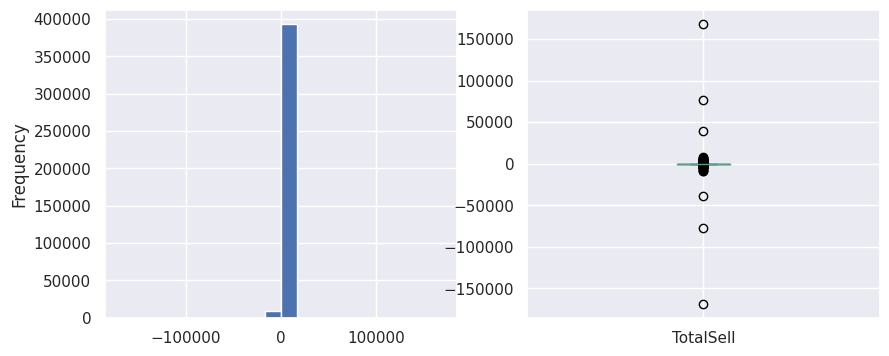

In [ ]:
#Cek Outlier pada Total Harga

fig, ax = plt.subplots(ncols=2,figsize=(10,4))

df_clean['TotalSell'].plot(kind='hist',bins=20,ax=ax[0])
df_clean['TotalSell'].plot(kind='box',ax=ax[1])

In [ ]:
# Melihat proporsi data yang diditeksi sebagai ouliers dengan metode Z-score
avg = df_clean['TotalSell'].mean()
std = df_clean['TotalSell'].std()

up_bound = avg + 3*std
low_bound = avg - 3*std

print(f'Upper Boundary: {up_bound:.2f}' )
print(f'Lower Boundary: {low_bound:.2f}')

Upper Boundary: 1311.67
Lower Boundary: -1270.44


In [ ]:
outlier = df_clean['TotalSell'][(df_clean['TotalSell']<low_bound) | (df_clean['TotalSell']>up_bound)]
no_outlier = df_clean['TotalSell'][(df_clean['TotalSell']>=low_bound) & (df_clean['TotalSell']<=up_bound)]

print(f'Percentage of outliers: {len(outlier)*100/len(df_clean["TotalSell"]):.2f}%')

Percentage of outliers: 0.06%


Insight:
- Sebanyak 0.06% dideteksi sebagai ouliers data, dengan kata lain terdapat anomali data yang tidak wajar dari transaksi terjadi dari batas atas yang dipatok pada nilai 1311,67 dan batas bawah yang dipatok -1270,44
- Jumlah outliers yang ada pada data sedikit namun begitu nilai ouliers yang ada sangat ekstrim jika dibandingkan dengan data lainnya. Sehingga perlu dilakukan analisis lebih lanjut tentang data dengan nilai ekstrim tersebut.

---

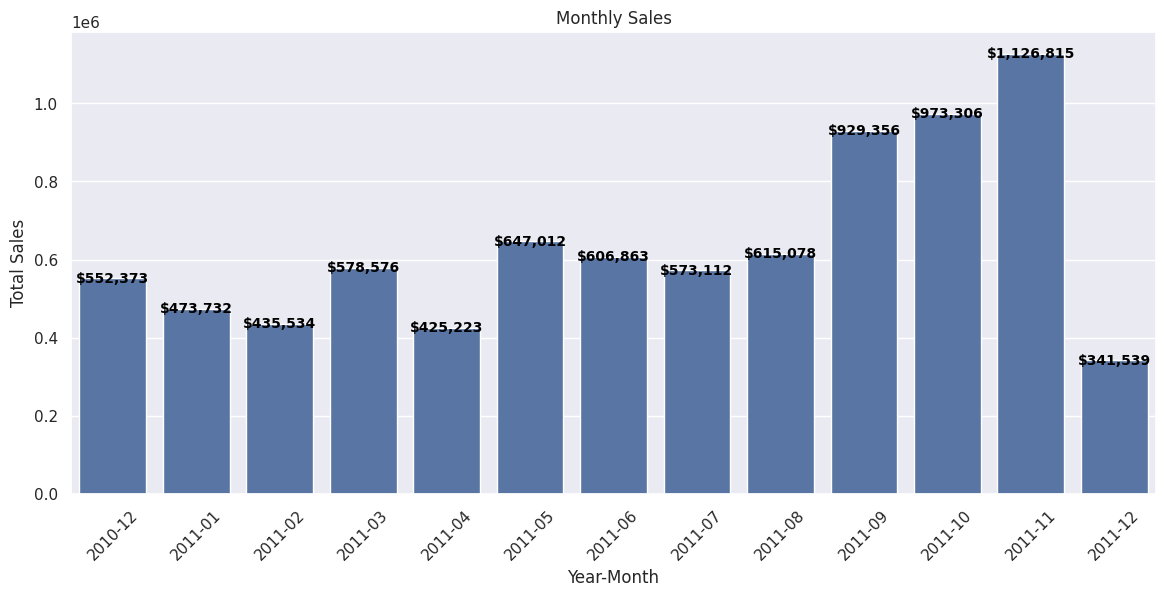

In [ ]:
# Melihat total pendapatan pada setiap Bulan
monthly_sales = df_clean.groupby('Year_Month')['TotalSell'].sum().reset_index()

# Plotting data
plt.figure(figsize=(14, 6))
barplot = sns.barplot(x='Year_Month', y='TotalSell', data=monthly_sales)
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales')
for p in barplot.patches:
    barplot.annotate(f'${p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', weight='bold')
plt.show()

In [ ]:
# Menghitung Korelasi dan P-value
corr_rho, pval_s = stats.spearmanr(monthly_sales['Year_Month'].astype(str), monthly_sales['TotalSell'])
print(f"rho-correlation: {corr_rho:.2f}, p-value: {pval_s:.4f}")

rho-correlation: 0.43, p-value: 0.1383


***Insight*** : Korelasi yang terjadi pada penjualan menunjukan trend positif dengan nilai korelasi 0.43 dengan nilai p-value 0.1383


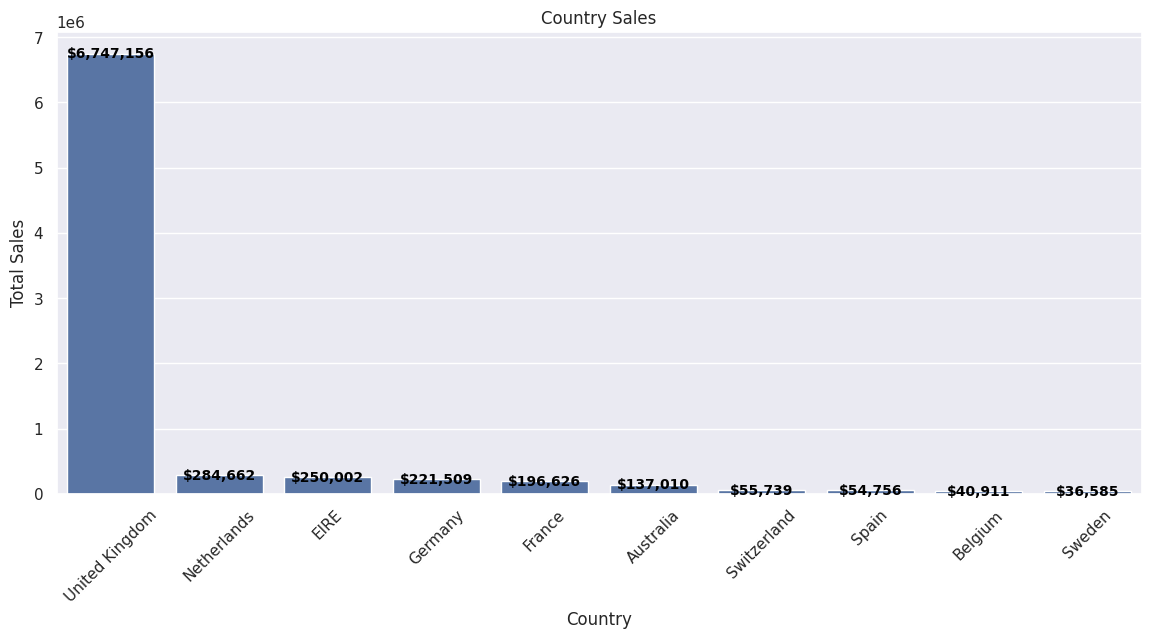

In [ ]:
# Melihat total pendapatan berdasarkan Customers Country
country_sales = df_clean.groupby('Country')['TotalSell'].sum().reset_index()

# Mengambil 10 data country dengan pendapatan tebesar
top_10_sales = country_sales.nlargest(10, 'TotalSell')

# Plotting data
plt.figure(figsize=(14, 6))
barplot = sns.barplot(x='Country', y='TotalSell', data=top_10_sales)
plt.xticks(rotation=45)
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.title('Country Sales')
for p in barplot.patches:
    barplot.annotate(f'${p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', weight='bold')
plt.show()

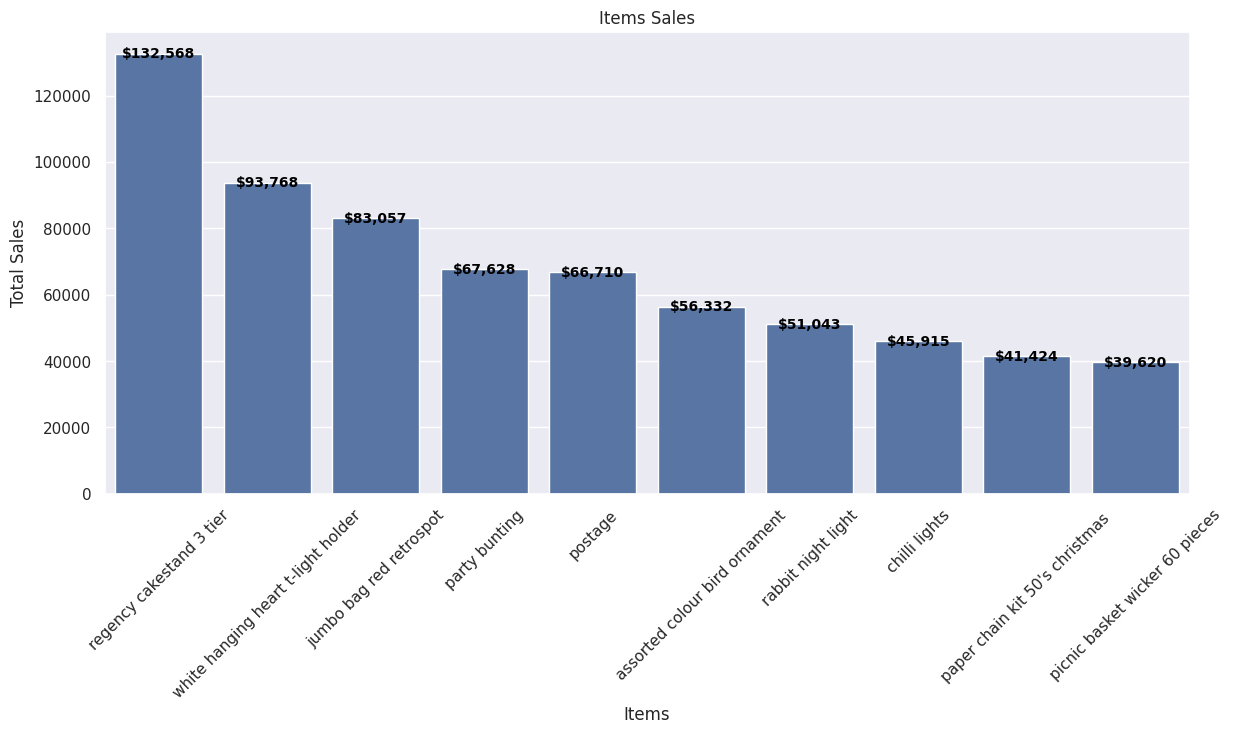

In [ ]:
# Melihat total pendapatan berdasarkan Customers Country
description_sales = df_clean.groupby('Items')['TotalSell'].sum().reset_index()

# Mengambil 10 data country dengan pendapatan tebesar
top_10_sales = description_sales.nlargest(10, 'TotalSell')

# Plotting data
plt.figure(figsize=(14, 6))
barplot = sns.barplot(x='Items', y='TotalSell', data=top_10_sales)
plt.xticks(rotation=45)
plt.xlabel('Items')
plt.ylabel('Total Sales')
plt.title('Items Sales')
for p in barplot.patches:
    barplot.annotate(f'${p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', weight='bold')
plt.show()

In [ ]:
# Filter data untuk 'United Kingdom'
uk_data = df_clean[df_clean['Country'] == 'United Kingdom']

# Menghitung Total Price dari country dan Description
uk_sales_sell = uk_data.groupby(['Country','Items']).agg({'TotalSell': 'sum'}).reset_index()

# Mengurutkan hasil berdasarkan TotalPrice
uk_sales_sorted_sell = uk_sales_sell.sort_values(by='TotalSell', ascending=False)

uk_sales_sorted_sell.head(10)

,Country,Items,TotalSell
2751,United Kingdom,regency cakestand 3 tier,102871.15
3681,United Kingdom,white hanging heart t-light holder,88260.85
1756,United Kingdom,jumbo bag red retrospot,75236.43
2334,United Kingdom,party bunting,61893.48
214,United Kingdom,assorted colour bird ornament,52147.56
720,United Kingdom,chilli lights,45134.21
2383,United Kingdom,picnic basket wicker 60 pieces,39619.50
2302,United Kingdom,paper chain kit 50's christmas,39537.73
372,United Kingdom,black record cover frame,37780.67
3729,United Kingdom,wood black board ant white finish,33345.46


In [ ]:
# Filter data untuk 'United Kingdom'
uk_data = df_clean[df_clean['Country'] == 'United Kingdom']

# Menghitung Total Price dari country dan customerID
uk_sales_ID = uk_data.groupby(['Country','CustomerID']).agg({'TotalSell': 'sum'}).reset_index()

# Mengurutkan hasil berdasarkan TotalPrice
uk_sales_sorted_ID = uk_sales_ID.sort_values(by='TotalSell', ascending=False)

uk_sales_sorted_ID.head(10)

,Country,CustomerID,TotalSell
3811,United Kingdom,18102.0,256438.49
3340,United Kingdom,17450.0,187322.17
3382,United Kingdom,17511.0,88125.38
2788,United Kingdom,16684.0,65892.08
625,United Kingdom,13694.0,62690.54
1783,United Kingdom,15311.0,59284.19
193,United Kingdom,13089.0,57322.13
909,United Kingdom,14096.0,57120.91
1591,United Kingdom,15061.0,54228.74
2310,United Kingdom,16029.0,53168.69


In [ ]:
# Menghitung kerugian dari setiap transaksi items
df_loss = df_clean.loc[(df_clean['TotalSell']<0)]
df_loss_sorted = df_loss.sort_values(by='TotalSell', ascending=True)
df_loss_sorted.head(10)

,InvoiceNo,StockCode,Items,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year_Month,TotalSell
540422,C581484,23843,"paper craft , little birdie",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,2011-12,-168469.60
61624,C541433,23166,medium ceramic top storage jar,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,2011-01,-77183.60
222681,C556445,M,manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom,2011-06,-38970.00
422375,C573079,M,manual,-2,2011-10-27 14:15:00,4161.06,12536.0,France,2011-10,-8322.12
173277,C551685,POST,postage,-1,2011-05-03 12:51:00,8142.75,16029.0,United Kingdom,2011-05,-8142.75
173391,C551699,M,manual,-1,2011-05-03 14:12:00,6930.00,16029.0,United Kingdom,2011-05,-6930.00
160145,C550456,21108,fairy cake flannel assorted colour,-3114,2011-04-18 13:08:00,2.10,15749.0,United Kingdom,2011-04,-6539.40
160143,C550456,85123A,white hanging heart t-light holder,-1930,2011-04-18 13:08:00,2.55,15749.0,United Kingdom,2011-04,-4921.50
160141,C550456,48185,doormat fairy cake,-670,2011-04-18 13:08:00,6.75,15749.0,United Kingdom,2011-04,-4522.50
268027,C560372,M,manual,-1,2011-07-18 12:26:00,4287.63,17448.0,United Kingdom,2011-07,-4287.63


Dari Visualisasi diatas didapat insight bahwa:
- Pendapatan tertinggi didapat pada bulan 11 tahun 2011 dengan 1.126.815 dan terjadi trend positif pada penjualan tahun 2011.
- Negara dengan penghasil pendapatan tertinggi adalah United Kingdom dengan 6.747.156
- Items terjual dengan nilai terbesar adalah Regency Cakestand 3 Tier dengan nilai penjualan 132.568
- Penjualan item yang mendominasi di United Kindom adalah Regency Cakestand 3 Tier dengan nilai 102.871,15
- CustomerID dengan tingkat pembelian tertinggi di UK adalah ID = 18102 dengan nilai transaksi 256.438,49
- Nilai transaksi yang merugikan terjadi pada nomor invoice C581484 dengan nilai negatif 168.469,60

## ***Conclution***

Pada bagian ini didapat bahwa nilai positif pada Total Sell menunjukan pendapatan yang di dapat perseroan karena penjualan maka dari itu nilai negatif pada Total Sell dapat diasumsikan nilai retur yang terjadi pada operasi perseroan yang membuat perseroan kehilangan pendapatan. Secara keseluruhan operasi usaha perseroan mendapatkan trend positif pada tahun 2011 dari segi penjualan dengan pendapatan tertinggi terjadi pada bulan 11 tahun 2011. Negara tujuan penjualan terbesar adalah United Kingdom dengan nilai transaksi 6.747.156 dan Items yang memperoleh nilai penjualan tertinggi dengan Regency Cakestand 3 Tier. Demikian analisis terkait kegiatan operasi perseroan yang dapat menjadi alat bantu bagian terkait dalam menentukan langkah strategis berikutnya.

## ***Link Visualisasi Interaktif***

https://public.tableau.com/app/profile/dendy.dwinanda/viz/TablueVisualisationRetailOnline/Dashboard1?publish=yes